### Init

In [15]:
from dotenv import load_dotenv
from lib.seed import seed_prefix 
import sys, os 
load_dotenv()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
seed_prefix(seed = 42)

Seed Fix: 42


### [1]-[2]

In [16]:
from lib.dataset import data_split
import pandas as pd 
data_df = pd.read_csv(os.getenv('DATASHEET_PATH'))
data_dir = os.getenv('DATA_DIR')
train_df, test_df = data_split(data_df, split_num = 5)
test_df.to_csv('/home/eiden/eiden/PCOS-roi-classification/v2/data/datasheet_test.csv', encoding = 'utf-8-sig', index = False)
binary_use = True
num_classes = 1
test_df

,filename,"label|0:양성, 1:중간형, 2:악성",PID
0,0_R009_00001,0,R009
1,0_R014_00001,0,R014
2,0_R017_00001,0,R017
3,0_R019_00001,0,R019
4,0_R028_00001,0,R028
...,...,...,...
587,2_R893_00001,2,R893
588,2_R893_00002,2,R893
589,2_R893_00003,2,R893
590,2_R919_00001,2,R919


[Alert] Sample Dataset Use : True
2214


/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


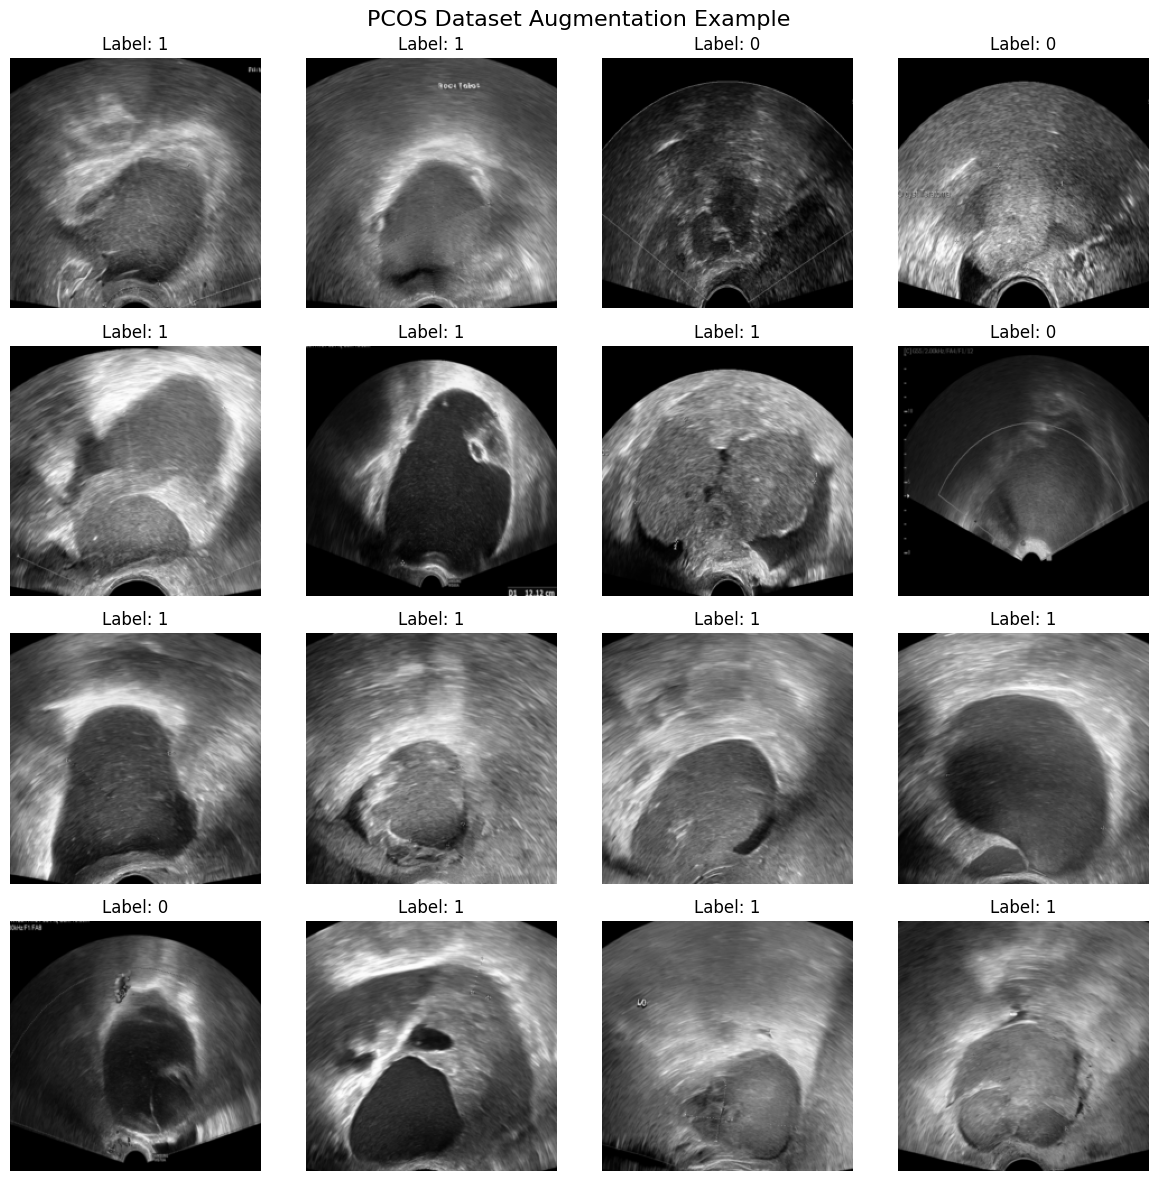

In [17]:
from lib.dataset import PCOS_Dataset
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
test_bs = 24

sample_df = pd.read_csv(os.getenv('SAMPLE_DATASHEET_PATH'))

test_dataset = PCOS_Dataset(
    data_filenames = test_df['filename'],
    data_dir_path  = data_dir,
    labels         = test_df['label|0:양성, 1:중간형, 2:악성'],
    
    # # [Sample Use] for Training
    sample_data_dir_path= os.getenv('SAMPLE_DATA_PATH'),
    sample_data_filenames= sample_df['filename'],
    sample_labels = sample_df['label|0:양성, 1:중간형, 2:악성'],
    
    binary_use = binary_use,
    need_paths = True,
    transform = v2.Compose([
        # v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        # v2.CenterCrop(252),
        # v2.Resize((224, 224)), # 먼저 296x296으로 Resize
        # v2.Grayscale(num_output_channels=3),
        # v2.ToTensor(),
        # v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        # v2.CenterCrop(252),           # 224x224 중앙 자르기 -> 0.7977
        v2.Resize((224, 224)), # 먼저 마지막으로 224처리
        # v2.RandomResizedCrop(224),           # 224x224 렌담 중앙 자르기 -> 0.8089
        # v2.RandomResizedCrop(224, scale = (0.8 ,1.2)),           # 224x224 렌담 중앙 줌인/줌아웃 자르기 -> 0.8089
        v2.Grayscale(num_output_channels=3),  # 3채널 회색변환 (RGB 형태 유지)
        v2.ToTensor(),                # 텐서 변환 
    ])
)
test_loader = DataLoader(test_dataset, batch_size = test_bs, shuffle = True, pin_memory=True, pin_memory_device= "cuda:0", persistent_workers=True, prefetch_factor = 4, num_workers= 8, )

print(len(test_dataset))
#%% Test Augmentation 
X, y, paths = next(iter(test_loader))
import matplotlib.pyplot as plt
try: 
    fig, axes = plt.subplots(4, 4, figsize = (12, 12))
    fig.suptitle('PCOS Dataset Augmentation Example', fontsize = 16)
    for i in range(16):
        axes[i//4, i%4].imshow(X[i].cpu().permute(1, 2, 0).numpy())
        axes[i//4, i%4].set_title(f'Label: {y[i].item():.0f}')
        axes[i//4, i%4].axis('off')

    plt.tight_layout()
    plt.show()
except:
    pass

# Model Load

In [4]:
import torch 
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
save_datetime = "2025-03-26_17-38-08"

#%% ckpt 파일 5개 추출 
from models import get_checkpoint_path
ckpt_paths = get_checkpoint_path(
    checkpoint_dir = './log/',
    datetime = save_datetime
)
#%% json 파일 내에서 model_name, model_version 추출
import simdjson as json
def get_model_series(filepath:str):
    with open(filepath, 'r') as f:
        model_series = json.load(f)
    model_name = model_series['model_name']
    model_version = model_series['model_version']
    return model_name, model_version

model_name, model_version = get_model_series(ckpt_paths[0].replace('.pth', '.json'))

#%% 모델 불러오기
from models import Model_Loader
model = Model_Loader(model_name = model_name + '_' + model_version, num_classes = num_classes).to('cuda')

def get_target_layers(model_name, model):
    if model_name == 'convnext':
        target_layers = [model.features[-1][-1].block] # ConvNext 
    elif model_name == 'resnet':
        target_layers = [model.layer4[-1]] # Resnet18
        
    return target_layers

target_layers = get_target_layers(model_name, model)

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Optimize, Loss 정의

#### [Settings] Train - Hyper Parmas 정의

In [6]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import datetime

In [7]:

from metric import calculate_metrics, plot_confusion_matrix_from_preds
from lib.pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad
)

from lib.pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from lib.pytorch_grad_cam.utils.image import show_cam_on_image
from visualize import plot_roc_curve


# Testing with K-Fold Grad CAM

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image 
metric_dict = dict()


# 폴드별 예측 확률 저장소 (shape: [fold, N, num_classes or 1])
all_fold_preds = []
# 실제 라벨은 모든 폴드에서 같으므로(동일 테스트셋) 한 번만 저장하면 됨
fixed_test_labels = None

for fold_num, ckpt_path in enumerate(ckpt_paths):
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()
    
    # fold별 CAM 결과 저장 디렉토리
    save_dir = ckpt_path.replace('.pth', '')
    os.makedirs(save_dir, exist_ok=True)
    
    # TP / FP / TN / FN 하위 폴더 미리 생성
    subfolders = ['TP', 'TN', 'FP', 'FN']
    for subf in subfolders:
        os.makedirs(os.path.join(save_dir, subf), exist_ok=True)
    
    
    all_preds = []
    all_labels = []
    
    for X, label, filepaths in tqdm(test_loader, total = len(test_loader), desc = f'Fold_{fold_num+1}'):
        with GradCAM(model = model, target_layers = target_layers) as cam:
            X, label = X.to(device), label.to(device)
            if len(X.shape) == 3: # (C, H, W) -> (B, C, H, W)
                X = X.unsqueeze(0)
            
            cam.batch_size = X.shape[0]
                
            y_res = model(X) # 모델 출력 B x Num Classes
            
            if binary_use:
                y_prob = torch.sigmoid(y_res).detach().cpu()
            else:
                y_prob = F.softmax(y_res, dim = 1).detach().cpu() # 확률 값 : B x Num Classes
            
            all_preds.append(y_prob)
            all_labels.append(label.detach().cpu())

            # ##%% Gray Scale CAM
            # grayscale_cam = cam(
            #     input_tensor = X, 
            #     targets = None,       # targets=None이면 classification score가 가장 높은 클래스에 대한 결과를 보여줌 -> Pred값 보여
            #     # targets = [ClassifierOutputTarget(label)] # 특정 class C에 대한 결과를 확인하려면 아래와 같이 설정
            #     eigen_smooth = True, # Flipping을 통해 실행시간이 x6으로 늘어나서 물체를 잘 보여주도록 함. 
            #     aug_smooth = True, #  # Noise를 제거하여 물체를 잘 보여주도록 함.
            # )
            
            # # 배치를 쪼개서 원본에 CAM 씌움
            # for idx, filepath in enumerate(filepaths):
            #     # (1) CAM mask 만들기
            #     cam_mask = grayscale_cam[idx].cpu().numpy() if torch.is_tensor(grayscale_cam[idx]) else grayscale_cam[idx] # # 만약 grayscale_cam[i]도 torch.Tensor라면 numpy로 변환 (이미 2D여야 함)
            #     # img를 numpy로 변환 & scailing img to 0~1
            #     img = np.asarray(Image.open(filepath).convert('RGB')) / 255.0
            #     # cam_mask size scaling to img size
            #     cam_mask = cv2.resize(cam_mask, (img.shape[1], img.shape[0]))
                
            #     visualization = show_cam_on_image(img, cam_mask, use_rgb=True, image_weight = 0.6)

            #     # (2) 예측 라벨과 실제 라벨 비교
            #     prob_value = y_prob[idx].item() # 확률값 (0~1)
            #     # fold마다 계산된 best threshold 사용
            #     pred_label = 1 if prob_value > 0.964 else 0
            #     true_label = label[idx].item()
            #     # (3) TP, TN, FP, FN 폴더 결정
            #     if pred_label == 1 and true_label == 1: # TP
            #         folder_name = 'TP'
            #     elif pred_label == 0 and true_label == 0: # TN
            #         folder_name = 'TN'
            #     elif pred_label == 1 and true_label == 0: # FP
            #         folder_name = 'FP'
            #     else:                                     # FN
            #         folder_name = 'FN'

            #     # (4) CAM 결과 이미지 저장
            #     dst_path = os.path.join(save_dir, folder_name, os.path.basename(filepath))
            #     cv2.imwrite(dst_path, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)) # 저장 
            # # 각 파일 처리 후 사용한 메모리 해제
            import gc
            gc.collect()
            
    #%% Test Metric 계산
    test_preds = torch.cat(all_preds, dim = 0)
    test_labels = torch.cat(all_labels, dim = 0)
    
    # Voting용
    all_fold_preds.append(test_preds)  
    fixed_test_labels = test_labels
    # [1] ROC Curve를 통해 최적 Threshold 찾기
    if binary_use:
        class_names = ['양성', '악성+중간형']
    else: 
        class_names = ['양성', '중간형', '악성']
    
    optimal_threshold = plot_roc_curve(
    true_labels=test_labels,
    pred_probs=test_preds,
    binary_use=binary_use,
    save_path = ckpt_path.replace('.pth' ,'_ROC.png'),
    class_names=class_names,
    )
    # [2] Confusion Matrix Plot -> 저장
    plot_confusion_matrix_from_preds(test_labels, test_preds, binary_use=binary_use, class_names=class_names, save_path = ckpt_path.replace('.pth' ,'_CM.png'), normalize=True, threshold= float(optimal_threshold))
    
    # [3] Best Metric 계산
    metric_dict[f'Fold_{fold_num+1}'] = calculate_metrics(labels = test_labels, preds = test_preds, binary_use = binary_use, threshold = float(optimal_threshold))
    metric_dict[f'Fold_{fold_num+1}']['Best Threshold'] = float(optimal_threshold)

    print(metric_dict[f'Fold_{fold_num+1}'])
    # 폴드 처리 후도 캐시 비우기
    torch.cuda.empty_cache()
    gc.collect()

metric_df = pd.DataFrame(metric_dict).T 
# 통계값 요약 : min, max ,mean 만 보기
print(metric_df.describe().loc[['min', 'max', 'mean']])
# Metric 저장

Fold_1: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


{'auc': 0.794570818468935, 'f1': 0.6514806378132119, 'accuracy': 0.7415540540540541, 'recall': 0.7185929648241206, 'Best Threshold': 0.04131702706217766}


Fold_2: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


{'auc': 0.8197348063472579, 'f1': 0.684085510688836, 'accuracy': 0.7753378378378378, 'recall': 0.7236180904522613, 'Best Threshold': 0.023375075310468674}


Fold_3: 100%|██████████| 25/25 [00:04<00:00,  5.65it/s]


{'auc': 0.797128134310228, 'f1': 0.6502242152466368, 'accuracy': 0.7364864864864865, 'recall': 0.7286432160804021, 'Best Threshold': 0.20499587059020996}


Fold_4: 100%|██████████| 25/25 [00:04<00:00,  5.53it/s]


{'auc': 0.8026775096858338, 'f1': 0.6681514476614699, 'accuracy': 0.7483108108108109, 'recall': 0.7537688442211056, 'Best Threshold': 0.009024846367537975}


Fold_5: 100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


{'auc': 0.779661667114197, 'f1': 0.6371681415929203, 'accuracy': 0.722972972972973, 'recall': 0.7236180904522613, 'Best Threshold': 0.08221042156219482}
           auc        f1  accuracy    recall  Best Threshold
min   0.779662  0.637168  0.722973  0.718593        0.009025
max   0.819735  0.684086  0.775338  0.753769        0.204996
mean  0.798755  0.658222  0.744932  0.729648        0.072185


In [10]:
#%% Soft Voting용 최종 결과 계산
ensemble_preds = torch.mean(torch.stack(all_fold_preds, dim=0), dim=0)
# 위 결과 shape: [N, num_classes or 1]
print(ensemble_preds.shape, fixed_test_labels.shape)
# 최종 소프트보팅에 대한 메트릭 계산
print("\n===== Soft-Voting 최종 결과 =====")
SoftVoting_opt_threshold = plot_roc_curve(
    true_labels=fixed_test_labels,
    pred_probs=ensemble_preds,
    binary_use=binary_use,
    save_path=ckpt_path.replace('fold5.pth' ,'AVG_ROC.png'),
    class_names=class_names,
)

plot_confusion_matrix_from_preds(
    fixed_test_labels, 
    ensemble_preds, 
    binary_use=binary_use, 
    class_names=class_names, 
    save_path=ckpt_path.replace('fold5.pth' ,'AVG_CM.png'),
    normalize=True, 
    threshold=float(SoftVoting_opt_threshold)
)

SoftVoting_metric = calculate_metrics(
    labels=fixed_test_labels, 
    preds=ensemble_preds, 
    binary_use=binary_use, 
    threshold=float(SoftVoting_opt_threshold)
)
SoftVoting_metric['Best Threshold'] = float(SoftVoting_opt_threshold)

# metric_df에 index로 softvoting이라고 하고, 해당 결과를 추가
all_metric_df = metric_df.copy()
all_metric_df.loc['SoftVoting'] = SoftVoting_metric
all_metric_df = all_metric_df.round(3)
all_metric_df.to_csv(ckpt_path.replace('fold5.pth' ,'metric.csv'), encoding = 'utf-8-sig')
all_metric_df

torch.Size([592, 1]) torch.Size([592])

===== Soft-Voting 최종 결과 =====


,auc,f1,accuracy,recall,Best Threshold
Fold_1,0.795,0.651,0.742,0.719,0.041
Fold_2,0.820,0.684,0.775,0.724,0.023
Fold_3,0.797,0.650,0.736,0.729,0.205
Fold_4,0.803,0.668,0.748,0.754,0.009
Fold_5,0.780,0.637,0.723,0.724,0.082
SoftVoting,0.812,0.668,0.750,0.749,0.135


: 

In [10]:
def binary_use_option(labels, borderline_to_class: str):
    """
    before_datasheet.csv (0 - 양성, 1 - 중간형, 2 - 악성)
    datasheet.csv         (0 - 양성, 1 - 악성, 2 - 중간형)

    borderline_to_class 에 따라:
    - "benign"          => label=2 를 1로, 나머지 0
    - "malignant"       => label=0 을 0으로, 나머지 1
    - "borderline to 1" => label=1 을 1로, 나머지 0
    """
    # 먼저 복사해서 경고 방지
    labels = labels.copy()

    if True:
        if borderline_to_class == "benign":
            # label=2 => 1, 그 외 => 0
            labels = (labels == 2).astype(int)
        elif borderline_to_class == "malignant":
            # label=0 => 0, 그 외 => 1
            labels = (labels != 0).astype(int)
        elif borderline_to_class == "borderline to 1":
            # label=1 => 1, 그 외 => 0
            labels = (labels == 1).astype(int)

    return labels

In [11]:


import pandas as pd 
labels = pd.Series([0,1, 2])
binary_use_option(labels, borderline_to_class = "benign")

0    0
1    0
2    1
dtype: int64

In [12]:
labels = pd.Series([0,1, 2])

binary_use_option(labels, borderline_to_class = "malignant")

0    0
1    1
2    1
dtype: int64

In [13]:
labels = pd.Series([0,1, 2])
binary_use_option(labels, borderline_to_class = "borderline to 1")


0    0
1    1
2    0
dtype: int64

In [14]:
import pandas as pd 

labels = pd.Series([0, 1, 2])


for label in labels:
    label = 0 if label == 0 else 1 # 보더라인을 악성에 붙힌 경우 : 
    print(label)
    

0
1
1


In [15]:
labels = pd.Series([0, 1, 2])

for label in labels:
    label = 1 if label == 2 else 0 # 보더라인을 양성에 붙힌 경우 : 0.75161
    print(label)
    

0
0
1


In [16]:
labels = pd.Series([0, 1, 2])

for label in labels:
    label = 1 if label == 0 else 0 # 반대로 지정해보기 1 : 양성 / 0 : 악성 및 보더라인
    print(label)
    

1
0
0


In [17]:
first_dict = {'abc' : 1}
second_dict = {'def' : 2}
# {'def' : 2} 결합
combined_dict = {**first_dict, **second_dict}
combined_dict

{'abc': 1, 'def': 2}